# North Carolina Public Schools Education Data Mini Project

***

## Introduction


 

In our previous project, we explored the North Carolina Public High Schools Dataset and visualized how school features are correlated with college enrollment percentage. There are several interesting findings from last project: from school education only, school features such as school fundings, school performance, school environment, teacher experience level, teacher qualification level are all affecting student performance in terms of SAT score and college enrollment percentage.  

In this project, we will create a binary response variable: a value of 1 represents the class that a student graduates from a certain school with certain features is going to college and a value of 0 represents the class that not going to college.Then we are going to select features like school fundings, school performance, school environment, teacher experience level, teacher qualification level. At last we will dive into using Logistic Regression and Support Vector Machines (SVMs) techniques to figure out the school factors that affect the college enrollment. 

***

## Analysis Strategy

We orginally wanted to explore how school features can affect the possibility of a student going to college. But a binary response is not in the original data set. Thus, we decided to focus on college enrollment percentage with gender division. A binary response variable is first set up by assigning class 1 to F_Female_ENROLL_sch_pct, then re-arranged the binary by setting a 0.5 threshold: assigning class 1 if the enrollment percentage is greate than 0.5. All the class 1 here represents the class that a student graduates from a certain school with certain features is going to college. 

With selected school features and classification techniques, we will give conclusions of the following questions: 

(placeholder here and it is just a thought that I have)
    
we can get the conclision first, then come back to fill in the questions.


***

## 1. Library Loading & Data Preparation 

First, we initialize the data frames by reading the 2014-2017 .csv files from our data directory. 

In [59]:
# CODE REFERENCE: https://github.com/jakemdrew/EducationDataNC
# Alteration from reference code include removal of schoolYear as these will be fixed years in the following section. 

#import required Libraries
import pandas as pd
from pandas.tools.plotting import boxplot
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# scikit learn package importation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import datasets
from sklearn.feature_selection import RFE

#**********************************************************************************
# Set the following variables before running this code!!!
#**********************************************************************************

#Location where copies of the raw data files will be downloaded and saved as csv files.
directory = directory = 'C:/Conda/STUDY/data_mining/term_project/project1/HighML/'

#### Reference: Snippets of this code block was taken directly from Eric Larson git repository: https://github.com/eclarson ####
#### Reference: https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas

df_2014ML = pd.read_csv(directory + 'PublicHighSchools2014_ML.csv') # read in the csv file
df_2014ML['year'] = 2014
# print('*********************************Before: 2014 Public High School Data*********************************')
# df_2014ML.info(verbose=False)

df_2015ML = pd.read_csv(directory + 'PublicHighSchools2015_ML.csv') # read in the csv file 
df_2015ML['year'] = 2015
# print('*********************************Before: 2015 Public High School Data*********************************')
# df_2015ML.info(verbose=False)

df_2016ML = pd.read_csv(directory + 'PublicHighSchools2016_ML.csv') # read in the csv file 
df_2016ML['year'] = 2016
# print('*********************************Before: 2016 Public High School Data*********************************')
# df_2016ML.info(verbose=False)

df_2017ML = pd.read_csv(directory + 'PublicHighSchools2017_ML.csv') # read in the csv file 
df_2017ML['year'] = 2017
# print('*********************************Before: 2017 Public High School Data*********************************')
# df_2017ML.info(verbose=False)

#Combine data
#### Reference https://pandas.pydata.org/pandas-docs/stable/merging.html
df_final = pd.concat([df_2014ML,df_2015ML,df_2016ML,df_2017ML], axis=0, join='inner', ignore_index=True)
#print('*********************************After: Combined Public High School Data*********************************')
#print('*********************************Verbose=True to show all column names and type of data********************')
#df_final.info(verbose=True)

# Write to local as csv format. Commented out for now, but here as a placeholder for us to use sometimes. 
#df_final.to_csv(directory + 'df_final.csv', sep=',', index=False)

print("Highschool Dataset Prepared")

Highschool Dataset Prepared


## 2. Create The Binary Response Variable 

In this step, we will create the binary response of the college enrollment percentage for the future classification analysis. 

In [60]:
# describe of two response variables :F_Female_ENROLL_sch_pct,M_Male_ENROLL_sch_pct
df_final[['F_Female_ENROLL_sch_pct','M_Male_ENROLL_sch_pct']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
F_Female_ENROLL_sch_pct,1904.0,40.513978,21.467421,0.0,28.163798,34.587017,53.176250,95.0
M_Male_ENROLL_sch_pct,1904.0,31.998886,19.458767,0.0,20.754717,26.884256,38.213056,95.0


In [61]:
# Unpivots df_final on F_Female_ENROLL_sch_pct and M_Male_ENROLL_sch_pct
# to create a gender_college_enroll for college enrollment model

valuevar = ["F_Female_ENROLL_sch_pct","M_Male_ENROLL_sch_pct"]
idvar = list(df_final)
idvar.remove('F_Female_ENROLL_sch_pct')
idvar.remove('M_Male_ENROLL_sch_pct')

df_operation = pd.melt(df_final, id_vars = idvar,                                            
                        value_vars=valuevar,
                        var_name='gender_college_enroll', value_name='ENROLL_sch_pct')
df_operation.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 288 entries, student_num to ENROLL_sch_pct
dtypes: float64(265), int64(22), object(1)
memory usage: 8.4+ MB


In [62]:
#  Binary attributes for collage enrollment of female and male.
#  binary_F_Female_ENROLL_sch_pct,binary_M_Male_ENROLL_sch_pct
#  1: Collage Enrollment Percentage larger than 0.5; 
#  0: Collage Enrollment Percentage smaller than 0.5

def f(row):
    if row['gender_college_enroll'] == 'F_Female_ENROLL_sch_pct':
        val = 1
    else:
        val = 0
    return val
df_operation['binary_gender_ENROLL_sch'] = df_operation.apply(f, axis=1)


def f(row):
    if row['ENROLL_sch_pct'] > 0.5:
        val = 1
    else:
        val = 0
    return val
df_operation['binary_ENROLL_sch_pct'] = df_operation.apply(f, axis=1)

After we create the binary response, we have 3583 records of class 1(likely to be enrolled) and 225 records of class 0(not likely to be enrolled)

In [63]:
#check for class bias based on our thresholds used.  
df_operation['binary_ENROLL_sch_pct'].value_counts()

1    3583
0     225
Name: binary_ENROLL_sch_pct, dtype: int64

Now, the binary response variable has been assigned to dataframe df_target and the features have been assigned to dataframe df_feat.

In [64]:
df_target = df_operation.binary_ENROLL_sch_pct
df_feat = df_operation.drop(['binary_ENROLL_sch_pct','ENROLL_sch_pct','gender_college_enroll'], axis=1)

## 3.  Logistic Regression 

### 3.1 Feature Selection Overview.

After concatinating datasets from 2014 to 2017, we realize that there are in total 228 attributes. Thus, we will narrow down the attributes for classfication process. 

- The feature selection has two part:
    1. Recursive Feature Elimination by keeping 20 attirubtes from the original.
    
    2. Manully selected features that we consider may affect college enrollment from the following four aspects: 
        
        
-  school funding attirubtes
      

|     Column Name     |      Description     |     
|     :-     |     -------------:     |     :-:     
|     lea_avg_student_num     |Average school size within the LEA
|     lea_total_expense_num     |Total expense (Dollars Spent) at LEA level
|     lea_salary_expense_pct     |Percent of expense spent on Salaries at LEA level
|     lea_services_expense_pct     |Percent of expense spent on Services at LEA level
|     lea_supplies_expense_pct     |Percent of expense spent on Supplies at LEA level
|     lea_instruct_equip_exp_pct     |Percent of expense spent on Instructional Equipment at LEA 
|     lea_federal_perpupil_num     |Federal expense per pupil at LEA level
|     lea_local_perpupil_num     |Local expense per pupil at LEA level
|     lea_state_perpupil_num     |State expense per pupil at LEA level



-  school performance, school environment & student scores attributes:


|     Column Name     |      Description     |     
|     :-     |     -------------:     |     :-:   
|     SPG Score     |school performace grades(numeric)
|     EVAAS Growth Score     |EVVAS: provide a score to evaluate the education effectiveness
|     sat_avg_score_num     |Average SAT Score (Critical Reading plus Math) at the School Level
|     sat_participation_pct     |Percentage of High School Seniors taking the SAT at the School Level
|     ap_participation_pct     |Percentage of High School Students taking an AP exam at the School Level
|     ap_pct_3_or_above     |Percentage of Advanced Placement Exams with Scores of 3 or Above at the School Level
|     total_specialized_courses     |Percent of students enrolled in at least one specialized course(CTE, AP/IB, Community College or University academic course) at the school level
|     univ_college_courses     |Percent of students enrolled in at least one academic course at a community college or university at the school level
|     avg_daily_attend_pct     |Average daily attendance percentage at school level	
|     crime_per_c_num     |	Number of crimes or acts of violence per 100 students at School level
|     short_susp_per_c_num     |Short term suspensions per 100 students at school level	
|     long_susp_per_c_num     |Long term suspensions per 100 students at School Level	
|     expelled_per_c_num     |Expulsions per 100 students at School Level
|     stud_internet_comp_num     |Ratio of students to internet connected computer at school level



-  teacher experience & teacher qualifications attributes:


|     Column Name     |      Description     |     
|     :-     |     -------------:     |     :-: 
|     flicensed_teach_pct     |Percent of teachers that meet NC fully licensed definition at school level	
|     tchyrs_0thru3_pct     |teaching experience year from 0-3 percentage	
|     tchyrs_4thru10_pct     |teaching experience year from 4-10 percentage
|     tchyrs_11plus_pct     |teaching experience year 11+ percentage
|     advance_dgr_pct     |Percent of teachers with masters or higher degree at school level
|     _1yr_tchr_trnovr_pct     |One Year Teacher turnover percentage at school level	
|     0-3 Years_LEA_Exp_Pct_Prin     |Percentage of principals at a 0-3 years of experience level at the district level
|     10+ Years_LEA_Exp_Pct_Prin     |Percentage of principals at a 10+ years of experience level at the district level
|     4-10 Years_LEA_Exp_Pct_Prin     |Percentage of principals at a 4-10 years of experience level at the district level



-  minority division attributes:

|     Column Name     |      Description     |     
|     :-     |     -------------:     |     :-: 
|     GraduationRate_4yr_Female     |GraduationRate 4 years for female
|     GraduationRate_4yr_Male     |GraduationRate 4 years for male
|     GraduationRate_5yr_All     |GraduationRate 5 years for all	
|     GraduationRate_5yr_Female     |GraduationRate 5 years for female
|     GraduationRate_5yr_Male     |GraduationRate 5 years for male
|     GraduationRate_4yr_Asian     |GraduationRate 4 years for Asians	
|     GraduationRate_5yr_Asian     |GraduationRate 5 years for Asians
|     GraduationRate_4yr_Black     |GraduationRate 4 years for Black 
|     GraduationRate_5yr_Black     |GraduationRate 5 years for Black 
|     GraduationRate_4yr_Hispanic     |GraduationRate 4 years for Hispanic 
|     GraduationRate_5yr_Hispanic     |GraduationRate 5 years for Hispanic 
|     GraduationRate_4yr_TwoorMoreRaces     |GraduationRate 4 years for TwoorMoreRaces 
|     GraduationRate_5yr_TwoorMoreRaces     |GraduationRate 5 years for TwoorMoreRaces 
|     GraduationRate_4yr_White     |GraduationRate 4 years for White
|     GraduationRate_5yr_White     |GraduationRate 5 years for White
|     GraduationRate_4yr_EDS     |GraduationRate 4 years for Economically Disadvantaged
|     GraduationRate_5yr_EDS     |GraduationRate 5 years for Economically Disadvantaged
|     GraduationRate_4yr_LEP     |GraduationRate 4 years for Limited English Proficiency
|     GraduationRate_5yr_LEP     |GraduationRate 5 years for Limited English Proficiency
|     GraduationRate_4yr_SWD     |GraduationRate 4 years for Students With Disabilities
|     GraduationRate_5yr_SWD     |GraduationRate 5 years for Students With Disabilities
|     GraduationRate_4yr_AIG     |GraduationRate 4 years for Academically/Intellectually Gifted
|     GraduationRate_5yr_AIG     |GraduationRate 5 years for Academically/Intellectually Gifted
|     MinorityFemalePct     |percentage of certain subgroups, female
|     MinorityMalePct     |percentage of certain subgroups, male
|     MinorityPct     |percentage of certain subgroups
|     TwoOrMorePct     |percentage of certain subgroups

### 3.2  Recursive Feature Elimination.

RFE feature selection has been performed with keeping 20 attributes in model. The final selected features are as shown: 

|     Column Name     |      Description     |     
|     :-     |     -------------:     |     :-: 
|     binary_gender_ENROLL_sch     |binary response created last step, if female, the cell will have value of 1
|     MathGr10_pTarget_PctMet     |percentage of meeting the math grade 10 target
|     lea_nbpts_num     |Average number of National Board Certified staff at LEA level
|     ACTWorkKeys_SilverPlus_Asian     |Silver or Better Certificate Asian
|     ACTMath_ACTBenchmark_Black     |Silver or Better Certificate Black
|     10+ Years_LEA_Exp_Pct_Prin     |Percentage of principals at a 10+ years of experience level at the district level
|     ECODIS_Economically Disadvantaged_ENROLL_sch_pct     |percentage of economicaly disadvantaged students enrolled	
|     Accomplished_TCHR_Standard 3_Pct     |percentage of teacher that have level of accomplished and standard 3|
|     GraduationRate_5yr_White     |GraduationRate 5 years for White
|     Distinguished_TCHR_Standard 1_Pct     |percentage of teacher that have level of distinguished and standard 1
|     ACTCompositeScore_UNCMin_AmericanIndian     |ACT Composite Score, Met UNC Minimum,American Indian
|     Distinguished_TCHR_Standard 4_Pct     |percentage of teacher that have level of distinguished and standard 4
|     Distinguished_TCHR_Standard 5_Pct     |percentage of teacher that have level of distinguished and standard 5
|     calendar_type_txt_Regular School, Year-Round Calendar     |Description of school calendar and school type,regular school, binary
|     ACTMath_ACTBenchmark_LEP     |ACT math benchmarks for Limited English Proficiency
|     ACTScience_ACTBenchmark_EDS     |ACT science benchmarks for Economically Disadvantaged
|     lea_univ_college_courses     |Percent of students enrolled in at least one academic course at a community college or university at the LEA level
|     SPG Grade_B     |SPG score with grade B
|     ACTWriting_ACTBenchmark_LEP     |ACT writing benchmarks for Limited English Proficiency
|     ACT_pTarget_PctMet     |ACT target percentage met

The following is to create the RFE model to select attributes.

In [65]:
# Code reference: https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
# Reference: http://scikit-learn.org/stable/modules/feature_selection.html
# Recursive Feature Elimination
# This section might take a few minutes

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select attributes count that wish to keep in the model
keep_attributes = 20 
rfe = RFE(model, keep_attributes)
rfe = rfe.fit(df_feat,df_target)
# summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)

# Set display parameter
#pd.set_option('display.height', 300)
#pd.set_option('display.max_rows', 300)

# Create dataframe for feature selection output. 
# Selected attributes: Support = true
df_column = list(df_feat)
df_column_selection = pd.DataFrame()
df_column_selection['column']=df_column
df_column_selection['support']=rfe.support_
df_column_selection['ranking']=rfe.ranking_

print(df_column_selection.sort_values('ranking',ascending=True))

                                                column  support  ranking
286                           binary_gender_ENROLL_sch     True        1
174                            MathGr10_pTarget_PctMet     True        1
217                                      lea_nbpts_num     True        1
51                        ACTWorkKeys_SilverPlus_Asian     True        1
60                          ACTMath_ACTBenchmark_Black     True        1
222                         10+ Years_LEA_Exp_Pct_Prin     True        1
191   ECODIS_Economically Disadvantaged_ENROLL_sch_pct     True        1
226                   Accomplished_TCHR_Standard 3_Pct     True        1
109                           GraduationRate_5yr_White     True        1
234                  Distinguished_TCHR_Standard 1_Pct     True        1
38             ACTCompositeScore_UNCMin_AmericanIndian     True        1
237                  Distinguished_TCHR_Standard 4_Pct     True        1
238                  Distinguished_TCHR_Standard 5_

### 3.3  The Final Selected Features. 

After obtaining the features from Recursive Feature Elimination process, we combine them with the manually selected features to create the final seleted features for future analysis. 

In [66]:
# Create dataset with auto-selected and manual-selected attributes for building logistic regression model

# auto selected columns from Logistic Regression Feature Selection
auto_selected_columns = df_column_selection.loc[df_column_selection['support'] == True]['column'].tolist()

# manually selected columns 

# school features
exp_list = ['lea_total_expense_num','lea_salary_expense_pct','lea_services_expense_pct','lea_supplies_expense_pct','lea_instruct_equip_exp_pct','lea_federal_perpupil_num','lea_local_perpupil_num','lea_state_perpupil_num']

# performance scores list
school_performace = ['SPG Score','EVAAS Growth Score','sat_avg_score_num','sat_participation_pct','ap_participation_pct','ap_pct_3_or_above','total_specialized_courses','univ_college_courses','avg_daily_attend_pct','crime_per_c_num','short_susp_per_c_num','long_susp_per_c_num','expelled_per_c_num','stud_internet_comp_num']

# teacher qualifications
teachers = ['flicensed_teach_pct','tchyrs_0thru3_pct','tchyrs_4thru10_pct','tchyrs_11plus_pct','advance_dgr_pct','_1yr_tchr_trnovr_pct','0-3 Years_LEA_Exp_Pct_Prin','10+ Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin']

# minority division
graduation_rate = ['GraduationRate_4yr_Female','GraduationRate_4yr_Male','GraduationRate_5yr_All','GraduationRate_5yr_Female','GraduationRate_5yr_Male','GraduationRate_4yr_Asian','GraduationRate_5yr_Asian','GraduationRate_4yr_Black','GraduationRate_5yr_Black','GraduationRate_4yr_Hispanic','GraduationRate_5yr_Hispanic','GraduationRate_4yr_TwoorMoreRaces','GraduationRate_5yr_TwoorMoreRaces','GraduationRate_4yr_White','GraduationRate_5yr_White','GraduationRate_4yr_EDS','GraduationRate_5yr_EDS','GraduationRate_4yr_LEP','GraduationRate_5yr_LEP','GraduationRate_4yr_SWD','GraduationRate_5yr_SWD','GraduationRate_4yr_AIG','GraduationRate_5yr_AIG']
minority_group = ['MinorityFemalePct','MinorityMalePct','MinorityPct','TwoOrMorePct']    

primary_keys = ['unit_code','year']

selected_columns = list(set().union(auto_selected_columns,exp_list,school_performace,teachers,graduation_rate,minority_group,primary_keys ))

df_feat = df_feat[selected_columns]
df_feat1 = df_feat[auto_selected_columns]
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 78 columns):
flicensed_teach_pct                                      3808 non-null float64
EVAAS Growth Score                                       3808 non-null float64
GraduationRate_5yr_White                                 3808 non-null float64
GraduationRate_4yr_Male                                  3808 non-null float64
ACTMath_ACTBenchmark_LEP                                 3808 non-null float64
GraduationRate_5yr_Asian                                 3808 non-null float64
10+ Years_LEA_Exp_Pct_Prin                               3808 non-null float64
MinorityPct                                              3808 non-null float64
total_specialized_courses                                3808 non-null float64
calendar_type_txt_Regular School, Year-Round Calendar    3808 non-null int64
long_susp_per_c_num                                      3808 non-null float64
tchyrs_4thru10_pct        

## 4. Training & Test Dataset Split

We used train_test_split to perform a train and test split. Here, the partition cut-off of is 0.2 which means we are using 80% of our final dataset for training set and the remaining is used as testing as. 

In [67]:

# from sklearn.model_selection import ShuffleSplit
# # we want to predict the X and y data as follows:
# if 'binary_F_Female_ENROLL_sch_pct' in df_logistic:
#     y = df_logistic['binary_F_Female_ENROLL_sch_pct'].values # get the labels we want
#     del df_logistic['binary_F_Female_ENROLL_sch_pct'] # get rid of the class label
#     x = df_logistic.values # use everything else to predict!

#     ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#     #    have converted them into simple matrices to use with scikit learn
        
# # to use the cross validation object in scikit learn, we need to grab an instance
# #    of the object and set it up. This object will be able to split our data into 
# #    training and testing splits

# num_cv_iterations = 3
# num_instances = len(y)
# cv_object = ShuffleSplit(n_splits=num_cv_iterations,
#                          test_size  = 0.2)
                         
# print(cv_object)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=0.20, random_state=3001)

## 5. Normalize The Data

We used the StandardScaler function in scikit-learn to normalize the attributes based on the mean and standard deviation of each column. Doing this will resolve problems if there are any wide range of differences in attributes.

In [31]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

## 6. Logistic Regression (LU's)

In [70]:
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from sklearn import metrics as mt

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

lr_clf = LogisticRegression(penalty='l2', C=0.05) # 
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print('confusion matrix:\n',conf )

# Create dataframe for results.
zip_vars=pd.DataFrame()
zip_vars['column name']=df_feat.columns
zip_vars['weight']=lr_clf.coef_.T
# sort by weight and reset index of zip_vars
zip_vars = zip_vars.sort_values('weight',ascending=False)
zip_vars.reset_index(drop=True,inplace=True)
print(zip_vars)

accuracy: 0.9868766404199475
confusion matrix:
 [[ 29   7]
 [  3 723]]
                                          column name    weight
0    ECODIS_Economically Disadvantaged_ENROLL_sch_pct  0.800709
1                                                year  0.466608
2                              GraduationRate_5yr_All  0.394066
3                           GraduationRate_5yr_Female  0.387520
4                                   sat_avg_score_num  0.246540
5                                  ACT_pTarget_PctMet  0.182091
6                            lea_univ_college_courses  0.177317
7                            GraduationRate_5yr_White  0.171005
8                              GraduationRate_5yr_SWD  0.168389
9                            GraduationRate_4yr_White  0.166544
10                                          SPG Score  0.131848
11                                long_susp_per_c_num  0.128699
12                            GraduationRate_5yr_Male  0.128154
13                             le

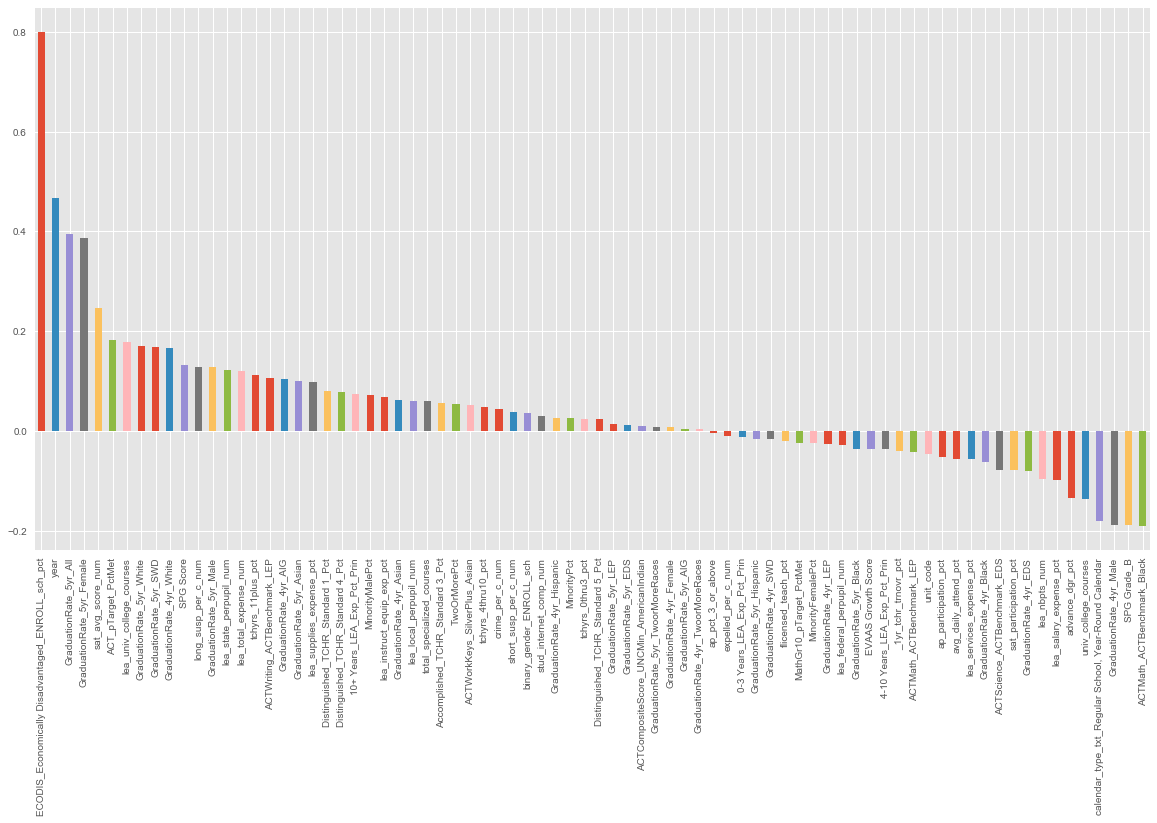

In [71]:
# now let's make a pandas Series with the names and values, and plot them
# Sorting by series value
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize = (20,10))
# Need to update this to like the top 20
weights = pd.Series(lr_clf.coef_[0],index=df_feat.columns)
weights = weights.sort_values(ascending=False)
weights.plot(kind='bar')
plt.show()

## 7. Support Vector Machines (Nuoya's)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

In simple words: **The ultimate goal of SVMS is the separation of classes.**

Reference:https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72

The results below show that we have **an accuracy score of ~98.95%** which is close to the **logistic model accuracy, ~98.68%**. In the confusion matrix, there is a zero value at the lower left ceell. This indicates that there is **no false negative**.

The following is the list that are often generated from a confusion matrix for a binary classifier:

|     Statistics     |      Values     |      Deescription
|     :-     |     -------------:     |     :-: 
|Accuracy|~98.95%|how often is the classifier correct?
|Misclassification Rate(aka Error Rate)|~1.05% |how often is it wrong?
|True Positive Rate(aka Sensitivity)|100% |When it's actually yes, how often does it predict yes?
| False Positive Rate|~22.22%|When it's actually no, how often does it predict yes?
|Specificity|~77.78%|When it's actually no, how often does it predict no?
|Precision|~98.91%|When it predicts yes, how often is it correct?
|Prevalence|~95.28%|How often does the yes condition actually occur in our sample?

Reference:http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

The following is to get the SVM model. Accuracy score and confusion matrix are presented.

In [101]:
# lets investigate SVMs on the data and play with the parameters and kernels# lets in 
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('============================')
print('Accuracy Score is:\n',acc )
print('============================')
print('Confusion Matrix is:\n',conf)

Accuracy Score is:
 0.989501312335958
Confusion Matrix is:
 [[ 28   8]
 [  0 726]]


Here is a brief summary of the support vectors.

In [91]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(539, 78)
(539,)
[142 397]


In [110]:
df_support = df_operation.loc[svm_clf.support_,:] # grab the support vectors and assign it to df_support
df_support['Going'] = df_target[svm_clf.support_] # add back in the 'Going' Column to the dataframe
df_operation['Going'] = df_target # also add it back in for the original data
df_support.info() # there are 539 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 30 to 3040
Columns: 292 entries, student_num to Going
dtypes: float64(265), int64(26), object(1)
memory usage: 1.2+ MB


In [108]:
df_operation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 292 entries, student_num to Going
dtypes: float64(265), int64(26), object(1)
memory usage: 8.5+ MB


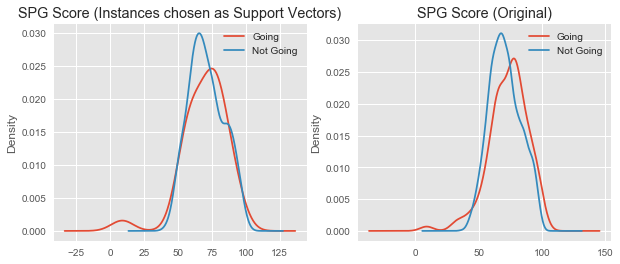

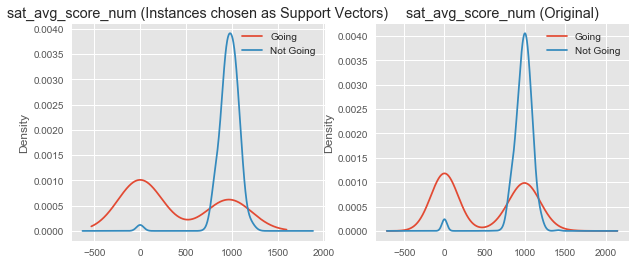

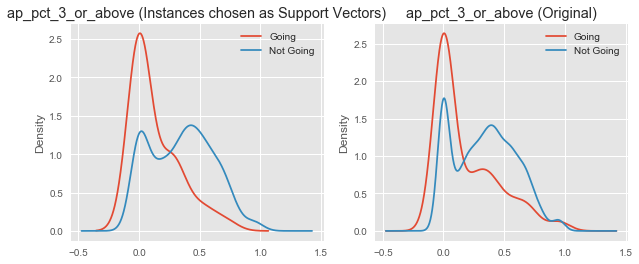

In [94]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Going'])
df_grouped = df_operation.groupby(['Going'])

# plot KDE of Different variables
vars_to_plot = ['SPG Score','sat_avg_score_num','ap_pct_3_or_above']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Going','Not Going'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Going','Not Going'])
    plt.title(v+' (Original)')